## GPT API를 사용하여 Fine-tuning 시켜보자
- fine-tuning에 필요한 데이터셋은 ChatCompletions API와 동일한 형식이 '대화'여야 하며, 각  메세지에 role별로 content가 들어간 메세지 목록이어야 함(system, user, assistants)
- fine-tuning시 최소 10개 이상의 대화 데이터가 필요하며, 비용상 처음부터 많은 양으로 학습시키기 보다는 50개 미만의 소량의 데이터 셋으로 학습시켜 결과를 확인해보고 필요시 추가하는 전략이 필요함
- openai 공식 페이지에서는 **100개 미만의 데이터**를 `소량의 데이터`라고 정의하고 있음
- 또한, 적어도 일부 학습 데이터에는 **기존 모델이 원하는대로 작동하지 않았을 경우**에 `제대로된 응답이 들어간 데이터`가 fine-tuning에 포함되어야 성능 향상을 크게 확인할 수 있음
    - **원하는대로 동작하지 않았던 응답**

    ```
          Q : 프랑스의 수도는 어디야?
          A : 프랑스는 세계에서 가장 유명한 관광도시예요!
    ```
    
    - **fine-tuning에 넣어줄 제대로된 데이터**

    ```
          Q : 프랑스의 수도는 어디야?
          A : 프랑스의 수도는 파리입니다.
    ```


In [19]:
!pip install tiktoken

In [1]:
from openai import OpenAI
from getpass import getpass
from datetime import datetime
from collections import defaultdict
import numpy as np
import time
import json
import tiktoken # openai 모델들이 사용하는 base 토큰화 + 인코딩 모듈

In [4]:
MY_API_KEY = getpass.getpass("OpenAI API Key :")

OpenAI API Key : ········


In [6]:
client = OpenAI(api_key=MY_API_KEY)

### 1.Fine-tuning 전 데이터 로드 및 검증
- fine-tuning은 비용이 많이들 수 있기 때문에 사전에 적합한 데이터 형태인지 검증하고 진행하는 것이 좋음
- OpenAI fine-tuning API 사용시에 데이터의 구조는 JSONL 형태여야함
- **JSONL(JSON Lines)** : 한 줄당 json 객체가 존재하는 형태로 일반 json에 비해 한 줄씩 또는 청크 단위로 읽고 쓰는 것이 더 효율적이며 대규모의 데이터세트에 적합함

In [11]:
data = [
    {"messages" : [{"role" : "system", 
         "content" : "You are a chatbot that gives clear answers."},
        {"role" : "user", 
         "content" : "What can i do here?"},
        {"role" : "assistant", 
         "content" : "Ask a question about he part you want."}
    ]},
    {"messages" : [{"role" : "system", 
         "content" : "Your are a chatbot that gives clear answers"},
        {"role" : "user", 
         "content" : "I fell sick"},
        {"role" : "assistant", 
         "content" : "Please describe your symptoms in detail"}
    ]}
]
with open("finetune_data/my_dataset.jsonl", "w", encoding="utf-8") as f :
    # JSONL 파일 저장시 한 줄에 JSON 객체(딕셔너리)를 하나씩 저장해주는 방식
    for i in data :
        f.write(json.dumps(i) + "\n")

### OpenAI 샘플용 JSONL 데이터 활용


In [20]:
data_path = "finetune_data/toy_chat_fine_tuning.jsonl"

with open(data_path, "r", encoding="utf-8") as f:
    # JSONL을 불러올 때도 내부의 JSON 객체들을 하나씩 불러오는 반복문을 작성해야함
    dataset = [json.loads(line) for line in f]

print("샘플 수 :", len(dataset))
dataset

# 하나의 messages에 role이 여러개 있는 것은 multi-tern 대화(질의 응답이 여러번 이루어진 것)

샘플 수 : 5


[{'messages': [{'role': 'system',
    'content': 'You are a happy assistant that puts a positive spin on everything.'},
   {'role': 'user', 'content': 'I fell off my bike today.'},
   {'role': 'assistant',
    'content': "It's great that you're getting exercise outdoors!"}]},
 {'messages': [{'role': 'system',
    'content': 'You are a happy assistant that puts a positive spin on everything.'},
   {'role': 'user', 'content': 'I lost my tennis match today.'},
   {'role': 'assistant', 'content': "It's ok, it happens to everyone."},
   {'role': 'user', 'content': 'But I trained so hard!'},
   {'role': 'assistant', 'content': 'It will pay off next time.'},
   {'role': 'user', 'content': "I'm going to switch to golf."},
   {'role': 'assistant', 'content': 'Golf is fun too!'},
   {'role': 'user', 'content': "I don't even know how to play golf."},
   {'role': 'assistant', 'content': "It's easy to learn!"}]},
 {'messages': [{'role': 'user', 'content': 'I lost my book today.'},
   {'role': 'assi

#### 실제 fine-tuning에서 사용할 시사 상식 대화 데이터(10개) 로드

In [103]:
with open("finetune_data/common_sense_train.jsonl", "r", encoding="utf-8") as f:
    dataset = [json.loads(line) for line in f]

print( "샘플 수 :", len(dataset))
dataset

샘플 수 : 10


[{'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': "제주도는 '삼다도'라고 불리기도 하는데 '삼다'에 해당되는 것은 무엇일까요?"},
   {'role': 'assistant',
    'content': "정답은 '여자', '바람', '돌' 이고 이 세가지가 많다고 해서 '삼다' 라고 불림."}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user',
    'content': '뮤지컬, 연극, 오페라, 음악회 등의 공연이 끝난 후에 관객이 박수를 보내 배우들을 다시 무대로 나오게 하는 것을 무엇이라 할까요?'},
   {'role': 'assistant',
    'content': "정답은 '커튼콜'이며 '앵콜'과는 달리 추가 무대를 요청하는 것이 아니라 단순히 등장을 요구하는 것."}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '프랑스의 수도는 어디인가요?'},
   {'role': 'assistant',
    'content': '프랑스의 수도는 파리임. 파리는 예술의 도시라고 불리며 세계 최고의 관광 도시 중 하나임.'}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '세계에서 가장 큰 바다는 무엇인가요?'},
   {'role': 'assistant',
    'content': '세계에서 가장 큰 바다는 태평양임. 태평양은 오대양의 하나로 지구 표면의 1/3을 차지하며 표면적

### 데이터 검증([OpenAI cookbook](http://cookbook.openai.com/examples/chat_finetuning_data_prep))
#### (1) Fine-tuning API의 규격에 맞는 데이터셋인지 검증

In [ ]:
# 존재하지 않는 key값이 들어오면 0을 기본값으로 함
format_errors = defaultdict(int) 

for ex in dataset: # ex는 하나의 대화(messages)로 dict형태

# 1) 대화데이터 형태가 dict가 아니면 +1
    if not isinstance(ex, dict):          # isinstance(객체명, 클래스명)으로 객체의 타입을 확인하여  True or False 반환
        format_errors["data_type"] += 1   # format_errors에는 {"data_type" : 0}인 상태가 디폴트로 생성
        continue                          # ex가 dict가 아니면, not(False) -> True 반환하여 +1

# 2) 대화데이터 존재하지 않으면 +1
    messages = ex.get('messages', None) # messages의 value값이 있는지 없는지 판단
    if not messages:
        format_errors["missing_messages_list"] +=1
        continue

# 3) 대화데이터 형식에 맞는 key가 아니면 각각 +1
    for message in messages: # 채팅 API가 아닌 경우, role, content 외에 다른 key값이 있을 수 있음
        if any(key not in ("role", "content", "name", "function_call", "weight") for key in message): # any = 하나라도 True라면
            format_errors["message_unrecognized_key"] +=1      

        # message에 role과 content가 있는지 확인
        if "role" not in message or "content" not in message:
            format_errors['message_missing_key'] += 1

        #  role이 system, user, assistant 중 하나가 아니라면
        if message.get("role", None) not in ("system", "user", "assistant"):
            format_errors["unrecognized_role"] += 1

        # content에 값이 없거나 문자열이 아니라면
        content = message.get("content", None)
        if not content or not isinstance(content, str):
            format_errors["missing_content"] += 1 

# 4) 각 대화에 assistant의 응답이 하나도 없다면 +1
    # message들 중 하나라도 assistant의 응답이 있으면 any문은 전체를 T로 인식함
    if not any(message.get("role", None) == "assistant" for message in messages):
        format_errors["example_missing_assistant_message"] +=1

# 발생한 에러가 있다면 해당 내용 출력
if format_errors:
    print("에러 발견:")
    for key, value in format_errors.items():
        print(f"{key}:{value}")
else:
    print("에러가 없습니다.")
                

에러가 없습니다.


#### (2) 누락된 메세지 식별 및 메세지와 토큰 수 확인
- 필요한 함수 정의

In [111]:
encoding = tiktoken.get_encoding("cl100k_base") # get_encoding : 특정 토크나이저 인코딩 모델 검색
                                                # cl100k_base : OpenAI 최신 LLM에 사용되는 모델명

# 메세지 목록의 총 토큰 수 계산
def num_tokens_from_messages(messages, tokens_per_message=3, tokens_per_name=1):
    num_tokens = 0

    # tokens_per_message : role + content + {}를 토큰 3개로 임의 지정 (한 요소당 1로 대략 계산)
    for message in messages:
        num_tokens += tokens_per_message 

        # role과 content의 value를 tiktoken로 토큰화(encoding)하여 value의 토큰 개수 저장 
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))

            # key에 "name"이 존재하면 토큰 1개 추가 (사용자가 assistant의 이름을 지정할 경우 발생)
            if key == "name": 
                num_tokens += tokens_per_name

    # num_tokens += 3 하는 이유
     # 1) 하나의 messages에 전체를 감싸는 토큰 : "{}"
     # 2) 한 message의 끝을 표시하는 특수 토큰 (모델 내부에서 동작 <SEP> 등)
     # 3) 각각의 message를 구분해주는 구분 토큰 : ','
    num_tokens += 3 

    return num_tokens

# assistant가 응답한 content의 총 토큰 수 (모델의 max_output_tokens 기준에 맞는지 판단 가능)
def num_assistant_tokens_from_messages(messages):
    num_tokens = 0
    for message in messages:
        if message["role"] == "assistant":
            num_tokens += len(encoding.encode(message["content"])) # assistant의 content 토큰 수
    return num_tokens

# message의 토큰 길이에 대한 통계 정보 출력
def print_statistics(values):
    print(f"min / max : {min(values)}, {max(values)}")
    print(f"mean / median : {np.mean(values)}, {np.median(values)}")

In [113]:
# 토큰화 예시코드
encoding = tiktoken.get_encoding("cl100k_base")

print(encoding.encode("Hello my name is JinWoo"))
print(len(encoding.encode("Hello my name is JinWoo")))

[9906, 856, 836, 374, 39611, 54, 2689]
7


- 코드 및 함수 실행
- [모델별 토큰 수 ](https://platform.openai.com/docs/models)

In [116]:
max_output_tokens = 16384    # 모델 최대 출력 토큰 수(gpt-4o-mini의 경우 16384개)
n_missing_system = 0         # system이 없는 경우 대화 수
n_missing_user = 0           # user가 없는 경우의 대화 수
n_messages = []              # 각 대화의 message개수
total_tokens_lens = []       # 각 대화의 총 토큰 수
assistant_message_lens = []  # assistant가 보낸 메시지의 길이

for ex in dataset:
    messages = ex["messages"]

    # system이 누락됐다면 +1
    if not any(message["role"] == "system" for message in messages):
        n_missing_system += 1

    # user가 누락됐다면 +1
    if not any(message["role"] == "user" for message in messages):
        n_missing_user += 1

    # 각 대화별 메세지 개수
    n_messages.append(len(messages))

    # 각 대화별 총 토큰 개수(role도 다 포함)
    total_tokens_lens.append(num_tokens_from_messages(messages))

    # assistant's output 토큰 수
    assistant_message_lens.append(num_assistant_tokens_from_messages(messages))

print("System 누락 수 : ", n_missing_system)
print("User 누락 수 : ", n_missing_user)

print()
print("대화별 메시지 수 통계 : ")
print_statistics(n_messages)

print()
print("대화별 토큰 수 통계 : ")
print_statistics(total_tokens_lens)

print()
print("대화별 assistant 출력 토큰 수 통계 : ")
print_statistics(assistant_message_lens)

# total_tokens_lens(각 대화별 토큰 수 리스트)에서 최대값(16384)을 넘는 대화 수
n_too_long = sum(i > max_output_tokens for i in total_tokens_lens)

print()
print(f"\n{n_too_long}개의 대화가 {max_output_tokens}개 토큰 제한을 초과하며 이 부분은 학습중 잘릴 수 있습니다.")

System 메세지 누락 수 :  0
User 메세지 누락 수 :  0

### 대화 당 메시지 수 통계 : 
min / max : 3, 3
mean / median : 3.0, 3.0

### 대화 당 전체 토큰 수 통계 : 
min / max : 104, 178
mean / median : 125.4, 123.5

### 대화 당 assistant 출력 토큰 수 통계 : 
min / max : 37, 74
mean / median : 53.4, 53.5


0개의 대화가 16384개 토큰 제한을 초과하며 이 부분은 학습중 잘릴 수 있습니다.


#### (3) 적정 epochs 및 비용 추정
- [파인튜닝 토큰 수](https://platform.openai.com/docs/guides/fine-tuning)

In [119]:
# 모델에 맞는 대화당 최대 토큰 수 설정 (4o-mini의 Traning examples context length 기준)
MAX_TOKENS_PER_EXAMPLE = 65536

# OpenAI의 테스트에 의해 얻어진 적정 기준 (절대적인 기준은 아님!!!!!)
TARGET_EPOCHS = 3             # 초기 학습 횟수 (GPT는 보통 처음에 2~4회로 지정)
MIN_DEFAULT_EPOCHS = 1        # 최소 epochs
MAX_DEFAULT_EPOCHS = 25       # 최대 epochs
MIN_TARGET_EXAMPLES = 100     # fine-tuning 효과를 보기 위한 최소 데이터 수
MAX_TARGET_EXAMPLES = 25000   # 최대 데이터 개수 (비용 및 시간 효율을 위해 상한 설정)


# --------------- epoch 수 산정하기 ---------------
n_epochs = TARGET_EPOCHS         # 초기 학습 횟수
n_train_examples = len(dataset)  # messages의 개수

# 대화 수(messages) * 초기 학습 횟수(epochs)가 최소 데이터 수에 못 미치면
if (n_train_examples * TARGET_EPOCHS) < MIN_TARGET_EXAMPLES:
    n_epochs = min(MAX_DEFAULT_EPOCHS, (MIN_TARGET_EXAMPLES//n_train_examples))  
    
# 대화 수(messages) * 초기 학습 횟수(epochs)가 최대 데이터 수를 넘기면
elif (n_train_examples * TARGET_EPOCHS) > MAX_TARGET_EXAMPLES:
    n_epochs = max(MIN_DEFAULT_EPOCHS, (MAX_TARGET_EXAMPLES//n_train_examples))
# -----------------------------------------------


# 대화별 토큰 수 (total_tokens_lens)와 MAX_TOKENS_PER_EXAMPLE 중 더 작은 토큰 수 더하기
# MAX_TOKENS_PER_EXAMPLE(65536토큰)를 초과하면 어차피 나머지는 글은 잘리기 때문에
n_billing_tokens_in_dataset = sum(min(MAX_TOKENS_PER_EXAMPLE, length) for length in total_tokens_lens)


print(f"데이터 셋에는 학습 중 요금이 청구될 {n_billing_tokens_in_dataset}개의 토큰이 있습니다.")
print(f"기본적으로 이 데이터 셋에서 {n_epochs} epochs 동안 학습합니다.")
print(f"총 {n_epochs*n_billing_tokens_in_dataset}개의 토큰에 대해 요금이 청구됩니다.")

데이터 셋에는 학습 중 요금이 청구됨 1254개의 토큰이 있습니다.
기본적으로 이 데이터 셋에서 10 epoch 동안 학습합니다.
총 12540개의 토큰에 대해 요금이 청구됩니다.


##### **openai storage에 파일 업로드**

In [125]:
fine_tune_files = client.files.create(
    file = open("finetune_data/common_sense_train.jsonl", "rb"),  # rb를 하면 encoding이 필요 없음
    purpose = "fine-tune"
)
fine_tune_files

FileObject(id='file-AhnVfgLoBAcjauDU6JhqaC', bytes=6176, created_at=1739774316, filename='common_sense_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

### 3. Fine-tuning 작업 진행 및 결과 확인
- 1회 작업시 기본  epochs
    - gpt-3.5-turbo : 3epochs
    - gpt-4o 및 4o-mini : 4epochs
- **Fine-tuning이 완료된 모델**은 `OpenAI 서버에 저장`되며 작업에 할당된 모델 ID를 통해 액세스할 수 있음
- **작업이 완료되지 않으면** API `요금이 부과되지 않음`

#### 작업 객체 생성 및 fine-tuning 시작 ([모델명 참조](https://platform.openai.com/docs/guides/fine-tuning))

In [134]:
# 파인튜닝 모델, 데이터 지정
fine_tune_job = client.fine_tuning.jobs.create(
    model = "gpt-4o-mini-2024-07-18",     # docs - Fine-tuning에 있는 모델 사용
    training_file = fine_tune_files.id    # openai storage에 있는 파일의 id값을 지정
)

fine_tune_job

FineTuningJob(id='ftjob-Ft82dD32EH1jaOumUtXOFHEv', created_at=1739774714, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-eO0H2GRsXC2rA1ql6mCPGseH', result_files=[], seed=1754937279, status='validating_files', trained_tokens=None, training_file='file-AhnVfgLoBAcjauDU6JhqaC', validation_file=None, estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs='auto')), type='supervised'), user_provided_suffix=None)

##### 1) 작업 ID 가져오기

In [138]:
fine_tune_job.id

'ftjob-Ft82dD32EH1jaOumUtXOFHEv'

##### 2) 작업 ID에 따른 개별 작업 세부 사항 확인

In [151]:
# fine_tuned_model은 파인튜닝이 완료된 후 생성된 개인 모델 명칭
client.fine_tuning.jobs.retrieve("ftjob-Ft82dD32EH1jaOumUtXOFHEv").fine_tuned_model

'ft:gpt-4o-mini-2024-07-18:personal::B1pKdhoJ'

In [153]:
# status는 작업 상태를 표현해주며, running(동작중), validating_files(파일 검증), queued(대기),
# succeded(성공), fialed(실패), concelled(취소됨) 중 하나로 출력 됨
client.fine_tuning.jobs.retrieve("ftjob-Ft82dD32EH1jaOumUtXOFHEv").status

'succeeded'

##### 3) 작업로그, 성능 업데이트 또는 오류 메세지 같이 미세 조정 작업 중에 발생한 이벤트추척

In [162]:
# 모델, 에러 및 내용(발생시), 작업 상태, 사용된 데이터셋, 생성 및 완료 시간 등 확인 가능 (대시보드 - 파인튜닝 정보를 코드로 확인하는 것)
client.fine_tuning.jobs.list_events(fine_tuning_job_id ='ftjob-Ft82dD32EH1jaOumUtXOFHEv',
                                    limit =5)       # 출력 개수 제한

SyncCursorPage[FineTuningJobEvent](data=[FineTuningJobEvent(id='ftevent-299jUXCDvHjy5CVC5D5mE3AR', created_at=1739775358, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-Um76jM4fZ87o2CJFJbrrSvgQ', created_at=1739775347, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-8xouGjOAIY4OoU1AlcKHDFye', created_at=1739775347, level='info', message='Checkpoint created at step 90', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-GZMtM7tle7Qlh5IfRaYQeO2f', created_at=1739775347, level='info', message='Checkpoint created at step 80', object='fine_tuning.job.event', data={}, type='message'), FineTuningJobEvent(id='ftevent-SwJtvZRIZAItAEYe2mJgdQPm', created_at=1739775269, level='info', message='Step 100/100: training loss=0.00', object='fine_tuning.job.event', data={'s

##### 4) fine-tuning을 진행했던 전체 작업목록 출력(실행중 완료, 실패 작업들을 모두 포함)

In [165]:
client.fine_tuning.jobs.list()     # limit 매개변수를 통해 출력 개수를 제한할 수 있음

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-Ft82dD32EH1jaOumUtXOFHEv', created_at=1739774714, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal::B1pKdhoJ', finished_at=1739775344, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=10), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-eO0H2GRsXC2rA1ql6mCPGseH', result_files=['file-JRjJH6QMRS779HkGCf2Wpd'], seed=1754937279, status='succeeded', trained_tokens=8390, training_file='file-AhnVfgLoBAcjauDU6JhqaC', validation_file=None, estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=10)), type='supervised'), user_provided_suffix=None)], object='list', has_more=False)

##### 5) jobs.list에서 전체 작업 목록에 대한 id만 확인

In [350]:
all_job_id = [job.id for job in client.fine_tuning.jobs.list()]
all_job_id

['ftjob-x2NOix27Qk6THUxkrQjk2I09', 'ftjob-Ft82dD32EH1jaOumUtXOFHEv']

##### 6) 작업취소

In [ ]:
# # 작업이 예쌍보다 오래 걸리거나 잘못 설정된 걸 알게 되었을 경우 중간에 취소 가능
# client.fine_tuning.jobs.cancel("") # ""안에 모델 id 넣어주면 됨

##### 7) 완성된 fine_tuning모델 삭제

In [ ]:
# # 홈페이지에 있는 개인 모델 명칭을 지정
# client.models.delete("") # id 아니고 모델 명칭 넣기

#### Fine-tuning 완료된 작업 검색 (Python 코드를 사용하지 않는 수동 방식)
- 계층구조를 사람이 보기 쉽게 출력 가능
- !curl : 다양한 프로토콜을 사용하여 데이터를 전송하는데 널리 사용되는 명령도구로 API와 직접 상호작용하는데 유용함
- H : HTTP 요청에 사용자 정의 header를 추가하는데 사용하는 옵션으로 header는 키-값 쌍으로 요청에 대한 추가 정보를 서버에 제공하게 됨(사용자 인증이나 컨텐츠 타입 등을 지정할 때 주로 사용함)

In [179]:
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-Ft82dD32EH1jaOumUtXOFHEv \
  -H "Authorization: Bearer $MY_API_KEY"

{
  "object": "fine_tuning.job",
  "id": "ftjob-Ft82dD32EH1jaOumUtXOFHEv",
  "model": "gpt-4o-mini-2024-07-18",
  "created_at": 1739774714,
  "finished_at": 1739775344,
  "fine_tuned_model": "ft:gpt-4o-mini-2024-07-18:personal::B1pKdhoJ",
  "organization_id": "org-eO0H2GRsXC2rA1ql6mCPGseH",
  "result_files": [
    "file-JRjJH6QMRS779HkGCf2Wpd"
  ],
  "status": "succeeded",
  "validation_file": null,
  "training_file": "file-AhnVfgLoBAcjauDU6JhqaC",
  "hyperparameters": {
    "n_epochs": 10,
    "batch_size": 1,
    "learning_rate_multiplier": 1.8
  },
  "trained_tokens": 8390,
  "error": {},
  "user_provided_suffix": null,
  "seed": 1754937279,
  "estimated_finish": null,
  "integrations": [],
  "method": {
    "type": "supervised",
    "supervised": {
      "hyperparameters": {
        "n_epochs": 10,
        "batch_size": 1,
        "learning_rate_multiplier": 1.8
      }
    }
  }
}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   898  100   898    0     0    581      0  0:00:01  0:00:01 --:--:--   584


### 4. Fine-tuning 완료 후 질의응답

In [205]:
completion = client.chat.completions.create(
    model = "ft:gpt-4o-mini-2024-07-18:personal::B1pKdhoJ",
    messages = [{"role" : "user", "content" : "우리나라의 첫 대통령은 누구인가?"}]
)
print(completion.choices[0].message.content)

우리나라의 첫 대통령은 이승만이며, 무소속 출신 이었음. 이승만은 1948년 대통령으로 선출되어 1960년까지 재임함.


#### Fine-tuning 결과가 좋지 않다고 판단될 경우 대응
**1) 데이터 부분**
1) 데이터 수 추가
    - 가장 효과가 확실한 방법
2) 데이터의 균형과 다양성 고려
    - 균형을 맞춰야 한다면 일반적으로 적은양의 고품질 데이터가 많은 양의 저품질 데이터보다 효과적
3) 기존 데이터의 문제점 조사
    - 원치않는 방식의 대화 데이터가 포함되어 있는지 확인(잘못된 패턴이 학습되었을 수 있음)
    - 응답에 필요한 모든 정보가 포함되어 있는지 확인
    - 여러 사람들이 함께 제작한 데이터라면 어느정도 일관성이 있는지 확인(패턴이 다 달라서 학습하기 힘들 수 있음)
      
**2) 모델 부분**
1) 완료된 모델에 추가로 fine-tuning 진행
    - 완료된 모델의 모델명으로 fine-tuning을 이어서 진행 가능
2) 하이퍼파라미터 변경
    - epochs, learning_rate를 변경 가능

### 5. 체크포인트(중간저장) 모델 활용하기
- Fine-tuning 완료 시 체크포인트 모델을 활용할 수 있으며 체크포인트 모델은 학습이 최종 완료된 모델과 동일한 방식으로 사용 가능
- 현재는 완료된 작업 총 3개의 체크포인트 모델들만 사용 가능함
- 최종 모델의 성능이 애매하거나 수치적으로 과대적합이라고 판단된다면 이전 체크포인트 모델들을 활용할 수 있음

#### 1) 체크포인트 모델 확인

In [221]:
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-Ft82dD32EH1jaOumUtXOFHEv/checkpoints \
  -H "Authorization: Bearer $MY_API_KEY"

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_kLRZU8Ar24grT61VhnxdHjuM",
      "created_at": 1739775277,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:personal::B1pKdhoJ",
      "fine_tuning_job_id": "ftjob-Ft82dD32EH1jaOumUtXOFHEv",
      "metrics": {
        "step": 100
      },
      "step_number": 100
    },
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_9CtBAXIlMzpaOHIlKgh7ohJC",
      "created_at": 1739775236,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:personal::B1pKc0Ml:ckpt-step-90",
      "fine_tuning_job_id": "ftjob-Ft82dD32EH1jaOumUtXOFHEv",
      "metrics": {
        "step": 90
      },
      "step_number": 90
    },
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_CoLME0LtUsrOYygAXSlvfXi5",
      "created_at": 1739775201,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:personal::B1pKc0Ii:ckpt-step-80",
      "fin

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1252  100  1252    0     0   2419      0 --:--:-- --:--:-- --:--:--  2464


#### 2) 체크포인트 모델 별 loss, mean_token_accuracy 확인

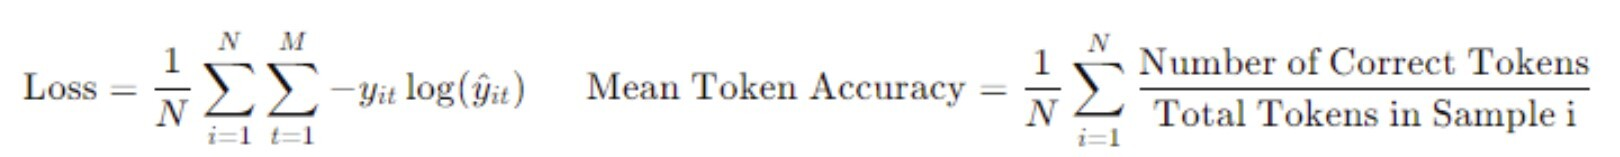

In [ ]:
# N : 데이터 개수
# M : 데이터 당 토큰 개수, 
# y : 실제 정답 토큰의 확률 (0 또는 1),
# y(hat) : 모델이 예측한 토큰 확률(sotfmax 적용, 0~1 사이 실수값)

##### **epochs당 결과 확인**

In [234]:
response = client.fine_tuning.jobs.list_events(
    fine_tuning_job_id = "ftjob-Ft82dD32EH1jaOumUtXOFHEv",
)

# loss는 낮아지고 train_mean_token_accuracy는 낮아지는지 확인
# model_dump_json : 객체를 json문자열로 변환하는 함수
print(response.model_dump_json(indent=4))

{
    "data": [
        {
            "id": "ftevent-299jUXCDvHjy5CVC5D5mE3AR",
            "created_at": 1739775358,
            "level": "info",
            "message": "The job has successfully completed",
            "object": "fine_tuning.job.event",
            "data": {},
            "type": "message"
        },
        {
            "id": "ftevent-Um76jM4fZ87o2CJFJbrrSvgQ",
            "created_at": 1739775347,
            "level": "info",
            "message": "New fine-tuned model created",
            "object": "fine_tuning.job.event",
            "data": {},
            "type": "message"
        },
        {
            "id": "ftevent-8xouGjOAIY4OoU1AlcKHDFye",
            "created_at": 1739775347,
            "level": "info",
            "message": "Checkpoint created at step 90",
            "object": "fine_tuning.job.event",
            "data": {},
            "type": "message"
        },
        {
            "id": "ftevent-GZMtM7tle7Qlh5IfRaYQeO2f",
            "create

### 6. Fine-tuning된 모델 추가 학습 및 검증용 데이터 활용

##### **추가 학습을 위한 데이터 상태 확인**

In [356]:
with open("finetune_data/common_sense_train_add.jsonl", "r", encoding="utf-8") as f:
    dataset = [json.loads(line) for line in f]

print( "샘플 수 :", len(dataset))
dataset

샘플 수 : 10


[{'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '화가 바뀌어 오히려 복이 된다 라는 뜻의 사자성어는 무엇인가요?'},
   {'role': 'assistant', 'content': "'전화위복'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '새끼 손가락을 지칭하는 명칭은 무엇인가요?'},
   {'role': 'assistant', 'content': "새끼 손가락은 '약지'이고 추가로 첫번째 손가락은 '엄지'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '물이 끓는 온도는 몇 도인가요?'},
   {'role': 'assistant', 'content': '물은 100도에서 끓음'}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '버스가 갑자기 정지하면 우리 몸이 앞으로 쏠리는 현상을 무엇이라고 하나요?'},
   {'role': 'assistant',
    'content': "'관성의 법칙'이라고 하며 가만히 있는 물체는 계속 가만히 있고, 움직이는 물체는 계속 움직이려는 현상을 뜻함"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '식물이 자라는 데 필요한 세 가지 요소는 무엇인가요?'}

##### **추가 학습 데이터 업로드**

In [261]:
fine_tune_files_add = client.files.create(
    file = open("finetune_data/common_sense_train_add.jsonl", "rb"),  # rb를 하면 encoding이 필요 없음
    purpose = "fine-tune"
)
fine_tune_files_add

FileObject(id='file-BNV3tX7Qhka8aTWuY5PTss', bytes=5167, created_at=1739780942, filename='common_sense_train_add.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

##### **검증용 데이터 확인**

In [263]:
with open("finetune_data/common_sense_val.jsonl", "r", encoding="utf-8") as f:
    dataset = [json.loads(line) for line in f]

print( "샘플 수 :", len(dataset))
dataset

샘플 수 : 5


[{'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user',
    'content': '더운 물과 찬 물을 섞었을 때, 열 때문에 물이 상하로 바뀌는 현상을 무엇이라고 하나요?'},
   {'role': 'assistant', 'content': "'대류현상'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '지구의 대기는 주로 어떤 기체로 이루어져 있나요?'},
   {'role': 'assistant', 'content': '대부분 질소와 산소로 이루어져 있음'}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '이집트 문명을 상징하는 대표적인 건축물은 무엇인가요?'},
   {'role': 'assistant', 'content': "세계 7대 불가사의에 포함되는 '피라미드'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '세계 최초의 인권선언은 무엇인가요?'},
   {'role': 'assistant', 'content': "1789년 프랑스 혁명 당시 발표된 '인간과 시민의 권리선언'"}]},
 {'messages': [{'role': 'system', 'content': '너는 지식이 풍부하지만 시크하게 응답하는 챗봇이야.'},
   {'role': 'user', 'content': '지구의 대륙 수는 몇 개인가요?'},
   {'role': 'assistant',
    'c

##### **검증용 데이터 업로드**

In [265]:
fine_tune_files_val = client.files.create(
    file = open("finetune_data/common_sense_val.jsonl", "rb"),  # rb를 하면 encoding이 필요 없음
    purpose = "fine-tune"
)
fine_tune_files_val

FileObject(id='file-Gepgjbx8HcimGDoqEAp2Di', bytes=2513, created_at=1739781023, filename='common_sense_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

##### **추가 Fine-tuning 및 검증 진행**

In [281]:
fine_tune_job_add = client.fine_tuning.jobs.create(
    model = "ft:gpt-4o-mini-2024-07-18:personal::B1pKdhoJ", # 기존 학습된 모델
    training_file = fine_tune_files_add.id,                 # 추가 학습 데이터 아이디
    validation_file = fine_tune_files_val.id,               # 검증용 데이터 아이디
    hyperparameters = {"n_epochs" : 5,
                       "learning_rate_multiplier" : 0.8
                      }
)

# learning_rate_multiplier(학습률)
# GPT-3.5/4 계열 모델: 0.1 ~ 0.5
# 데이터가 많고 Fine-Tuning 강도를 높이고 싶다면: 0.5 ~ 1.0
# 데이터가 적거나 기존 성능을 유지하면서 미세 조정하고 싶다면: 0.05 ~ 0.2

fine_tune_job_add

FineTuningJob(id='ftjob-x2NOix27Qk6THUxkrQjk2I09', created_at=1739781281, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier=0.8, n_epochs=5), model='ft:gpt-4o-mini-2024-07-18:personal::B1pKdhoJ', object='fine_tuning.job', organization_id='org-eO0H2GRsXC2rA1ql6mCPGseH', result_files=[], seed=1712883518, status='validating_files', trained_tokens=None, training_file='file-BNV3tX7Qhka8aTWuY5PTss', validation_file='file-Gepgjbx8HcimGDoqEAp2Di', estimated_finish=None, integrations=[], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier=0.8, n_epochs=5)), type='supervised'), user_provided_suffix=None)

In [287]:
# 수동 확인
!curl https://api.openai.com/v1/fine_tuning/jobs/ftjob-x2NOix27Qk6THUxkrQjk2I09/checkpoints \
  -H "Authorization: Bearer $MY_API_KEY"

{
  "object": "list",
  "data": [
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_zXpzkN4xQpDonJlFsa2bo1Uz",
      "created_at": 1739782006,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:personal::B1r4WJeg",
      "fine_tuning_job_id": "ftjob-x2NOix27Qk6THUxkrQjk2I09",
      "metrics": {
        "step": 50
      },
      "step_number": 50
    },
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_B71vYiNa1aVM3eB9Lpwkm0ob",
      "created_at": 1739781943,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:personal::B1r4WSHx:ckpt-step-40",
      "fine_tuning_job_id": "ftjob-x2NOix27Qk6THUxkrQjk2I09",
      "metrics": {
        "step": 40
      },
      "step_number": 40
    },
    {
      "object": "fine_tuning.job.checkpoint",
      "id": "ftckpt_1mJXe0wDob76ld9wzHoK6Z7d",
      "created_at": 1739781883,
      "fine_tuned_model_checkpoint": "ft:gpt-4o-mini-2024-07-18:personal::B1r4VlJj:ckpt-step-30",
      "fine_

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1250  100  1250    0     0   2248      0 --:--:-- --:--:-- --:--:--  2276


##### **Epoch별 확인**
- loss는 낮아지고 train_mean_token_accuracy는 낮아지는지 확인
- model_dump_json : 객체를 json문자열로 변환하는 함수

In [285]:
response = client.fine_tuning.jobs.list_events(
    fine_tuning_job_id = "ftjob-x2NOix27Qk6THUxkrQjk2I09",
)
print(response.model_dump_json(indent=4))

{
    "data": [
        {
            "id": "ftevent-pylW3g1PtMOSPPIIcJlwghPo",
            "created_at": 1739782003,
            "level": "info",
            "message": "Step 50/50: training loss=0.00, validation loss=1.29, full validation loss=0.90",
            "object": "fine_tuning.job.event",
            "data": {
                "step": 50,
                "train_loss": 0.0011444091796875,
                "valid_loss": 1.2855484220716689,
                "total_steps": 50,
                "full_valid_loss": 0.8958381952023974,
                "train_mean_token_accuracy": 1.0,
                "valid_mean_token_accuracy": 0.8333333333333334,
                "full_valid_mean_token_accuracy": 0.8431372549019608
            },
            "type": "metrics"
        },
        {
            "id": "ftevent-vk2iEVfpNB2cMxqbyceNE8jB",
            "created_at": 1739781996,
            "level": "info",
            "message": "Step 49/50: training loss=0.04, validation loss=0.92",
          